In [1]:
import math

import pandas as pd
from multiprocess import Pool
import numpy as np
import os
from graph import Graph

In [2]:
df = pd.read_csv('csv_files/vacancies_with_skills.csv', encoding='utf-8-sig', low_memory=False)
convert = pd.read_csv('csv_files/convert.csv', encoding='utf-8-sig')

In [3]:
def separate_by_years():
    path = 'csv_files/separated'

    if not os.path.isdir(path):
        os.mkdir(path)

    df['year'] = df.published_at.apply(lambda x: x[:4])

    for (year), data in df.groupby('year'):
        data.loc[:, data.columns != 'year'].to_csv(f'csv_files/separated/{year}.csv', index=False)

separate_by_years()

In [4]:
class Result:

    def __init__(self):
        self.salaries = {}
        self.salaries_vac = {}
        self.count = {}
        self.count_vac = {}
        self.area_sal = {}
        self.area_count = {}


class ResultYear:

    def __init__(self, year, count, salary, count_filter, salary_filter, data = None, filtered = None):
        self.year = year
        self.count = count
        self.salary = salary
        self.count_filter = count_filter
        self.salary_filter = salary_filter
        self.data = data
        self.filtered = filtered

In [5]:
def get_salary(x, convert_df):
    salary_from, salary_to, salary_currency, published_at = x['salary_from'], x['salary_to'], x['salary_currency'], x['published_at'][:7]
    if salary_currency != 'RUR' and salary_currency not in convert_df.columns or math.isnan(salary_from) and math.isnan(salary_to):
        return math.nan

    k = 1

    if salary_currency != 'RUR':
        k = convert_df[convert_df['date'] == published_at][salary_currency].values[0]

        if math.isnan(k):
            return math.nan

    salary = 0

    if math.isnan(salary_from) or math.isnan(salary_to):
        salary = salary_to if math.isnan(salary_from) else salary_from
    else:
        salary = math.floor((salary_from + salary_to) / 2)

    return math.floor(salary * k)


def handle_year(f, convert_df, filter_copied):
    data = pd.read_csv(f'csv_files/separated/{f}', encoding='utf-8-sig', low_memory=False)

    data['salary'] = data.apply(lambda x: get_salary(x, convert_df) if x['published_at'] not in ['2005-02-08T11:11:17+0300', '2005-08-15T13:22:01+0400'] else math.nan, axis=1)

    data.drop(columns=['salary_from', 'salary_to', 'salary_currency'])
    data = data.reindex(columns=['name', 'salary', 'area_name', 'published_at', 'key_skills'], copy=True)
    filtered = data[data['name'].str.lower().str.replace(' ', '').str.contains(filter_copied)]

    return ResultYear(data['published_at'].values[0][:4], data.shape[0], math.floor(data['salary'].mean()), filtered.shape[0], math.floor(filtered['salary'].mean()), data, filtered)

In [6]:
processes = []
data_arr = []
result = Result()

filter_names = ['web develop', 'веб разработчик', 'web разработчик', 'web programmer', 'web программист', 'веб программист', 'битрикс разработчик', 'bitrix разработчик', 'drupal разработчик', 'cms разработчик', 'wordpress разработчик', 'wp разработчик', 'joomla разработчик', 'drupal developer', 'cms developer', 'wordpress developer', 'wp developer', 'joomla developer', 'web developer', 'разработчик web', 'web-программист', 'web-разработчик']
filter_row = '|'.join(filter_names).replace(' ', '')
files = os.listdir('csv_files/separated')
args = map(lambda x: (x, convert.copy(deep=True), filter_row), files)

with Pool(processes = len(files)) as pool:
    for result_year in pool.starmap(handle_year, args):
        result.salaries[result_year.year] = result_year.salary
        result.salaries_vac[result_year.year] = result_year.salary_filter
        result.count[result_year.year] = result_year.count
        result.count_vac[result_year.year] = result_year.count_filter
        data_arr.append(result_year)

    result.salaries = dict(sorted(result.salaries.items(), key=lambda x: x[0]))
    result.salaries_vac = dict(sorted(result.salaries_vac.items(), key=lambda x: x[0]))
    result.count = dict(sorted(result.count.items(), key=lambda x: x[0]))
    result.count_vac = dict(sorted(result.count_vac.items(), key=lambda x: x[0]))

In [7]:
data_with_salary = pd.concat(map(lambda x: x.filtered, data_arr))
count = data_with_salary.shape[0]
percent = count / 100

correct_cities = data_with_salary \
    .groupby('area_name')['name'] \
    .count() \
    .loc[lambda x: x > percent]

result.area_count = (correct_cities.sort_values(ascending=False) / count).to_dict().items()

result.area_sal = data_with_salary.loc[data_with_salary.area_name.isin(correct_cities.index)] \
    .groupby('area_name')['salary'] \
    .mean() \
    .apply(lambda x: math.floor(x)) \
    .sort_values(ascending=False) \
    .head(10) \
    .to_dict()


In [8]:
print(result.salaries)
print(result.salaries_vac)
print(result.count)
print(result.count_vac)

{'2003': 41304, '2004': 42967, '2005': 44938, '2006': 41317, '2007': 44449, '2008': 48411, '2009': 44811, '2010': 44657, '2011': 46448, '2012': 47969, '2013': 53541, '2014': 49076, '2015': 51734, '2016': 61305, '2017': 60363, '2018': 65581, '2019': 69938, '2020': 72833, '2021': 83061, '2022': 95473}
{'2003': 30318, '2004': 30209, '2005': 32089, '2006': 40923, '2007': 41119, '2008': 41776, '2009': 41269, '2010': 44884, '2011': 44970, '2012': 50454, '2013': 45528, '2014': 51206, '2015': 55777, '2016': 58280, '2017': 63581, '2018': 68357, '2019': 74418, '2020': 79103, '2021': 95131, '2022': 101579}
{'2003': 1983, '2004': 7833, '2005': 16022, '2006': 33321, '2007': 53562, '2008': 75070, '2009': 52889, '2010': 93494, '2011': 142458, '2012': 173897, '2013': 234019, '2014': 259571, '2015': 284763, '2016': 332460, '2017': 391464, '2018': 517670, '2019': 535956, '2020': 489472, '2021': 287915, '2022': 91142}
{'2003': 14, '2004': 63, '2005': 154, '2006': 568, '2007': 871, '2008': 1216, '2009': 1

In [9]:
print("insert into web_profession_citylevel (city, fraction) values")
d = list((correct_cities.sort_values(ascending=False) / count * 100).to_dict().items())[:10]
for i, e in enumerate(d):
    print(f"('{e[0]}', {round(e[1], 2)})", end=',\n' if i != len(d) - 1 else ';')

insert into web_profession_citylevel (city, fraction) values
('Москва', 25.02),
('Санкт-Петербург', 11.57),
('Минск', 4.01),
('Киев', 3.35),
('Алматы', 2.89),
('Нижний Новгород', 2.63),
('Новосибирск', 2.47),
('Ростов-на-Дону', 1.98),
('Краснодар', 1.95),
('Казань', 1.9);

In [24]:
list((correct_cities.sort_values(ascending=False) / count).to_dict().items())[:10]

[('Москва', 0.2501809306219756),
 ('Санкт-Петербург', 0.11572464487930863),
 ('Минск', 0.04010274021200812),
 ('Киев', 0.03354666590983269),
 ('Алматы', 0.028934708879081582),
 ('Нижний Новгород', 0.02628105975677248),
 ('Новосибирск', 0.02469170841079056),
 ('Ростов-на-Дону', 0.019767557365650144),
 ('Краснодар', 0.01951212589933162),
 ('Казань', 0.019029644240729966)]

In [10]:
result.area_sal.items()

dict_items([('Киев', 83426), ('Москва', 79975), ('Минск', 67968), ('Санкт-Петербург', 67448), ('Новосибирск', 63658), ('Екатеринбург', 59426), ('Самара', 54982), ('Краснодар', 53836), ('Челябинск', 52650), ('Пермь', 52540)])

In [11]:
print("insert into web_profession_citysal (city, salary) values")
d = list(result.area_sal.items())
for i, e in enumerate(d):
    print(f"('{e[0]}', {round(e[1], 2)})", end=',\n' if i != len(d) - 1 else ';')

insert into web_profession_citysal (city, salary) values
('Киев', 83426),
('Москва', 79975),
('Минск', 67968),
('Санкт-Петербург', 67448),
('Новосибирск', 63658),
('Екатеринбург', 59426),
('Самара', 54982),
('Краснодар', 53836),
('Челябинск', 52650),
('Пермь', 52540);

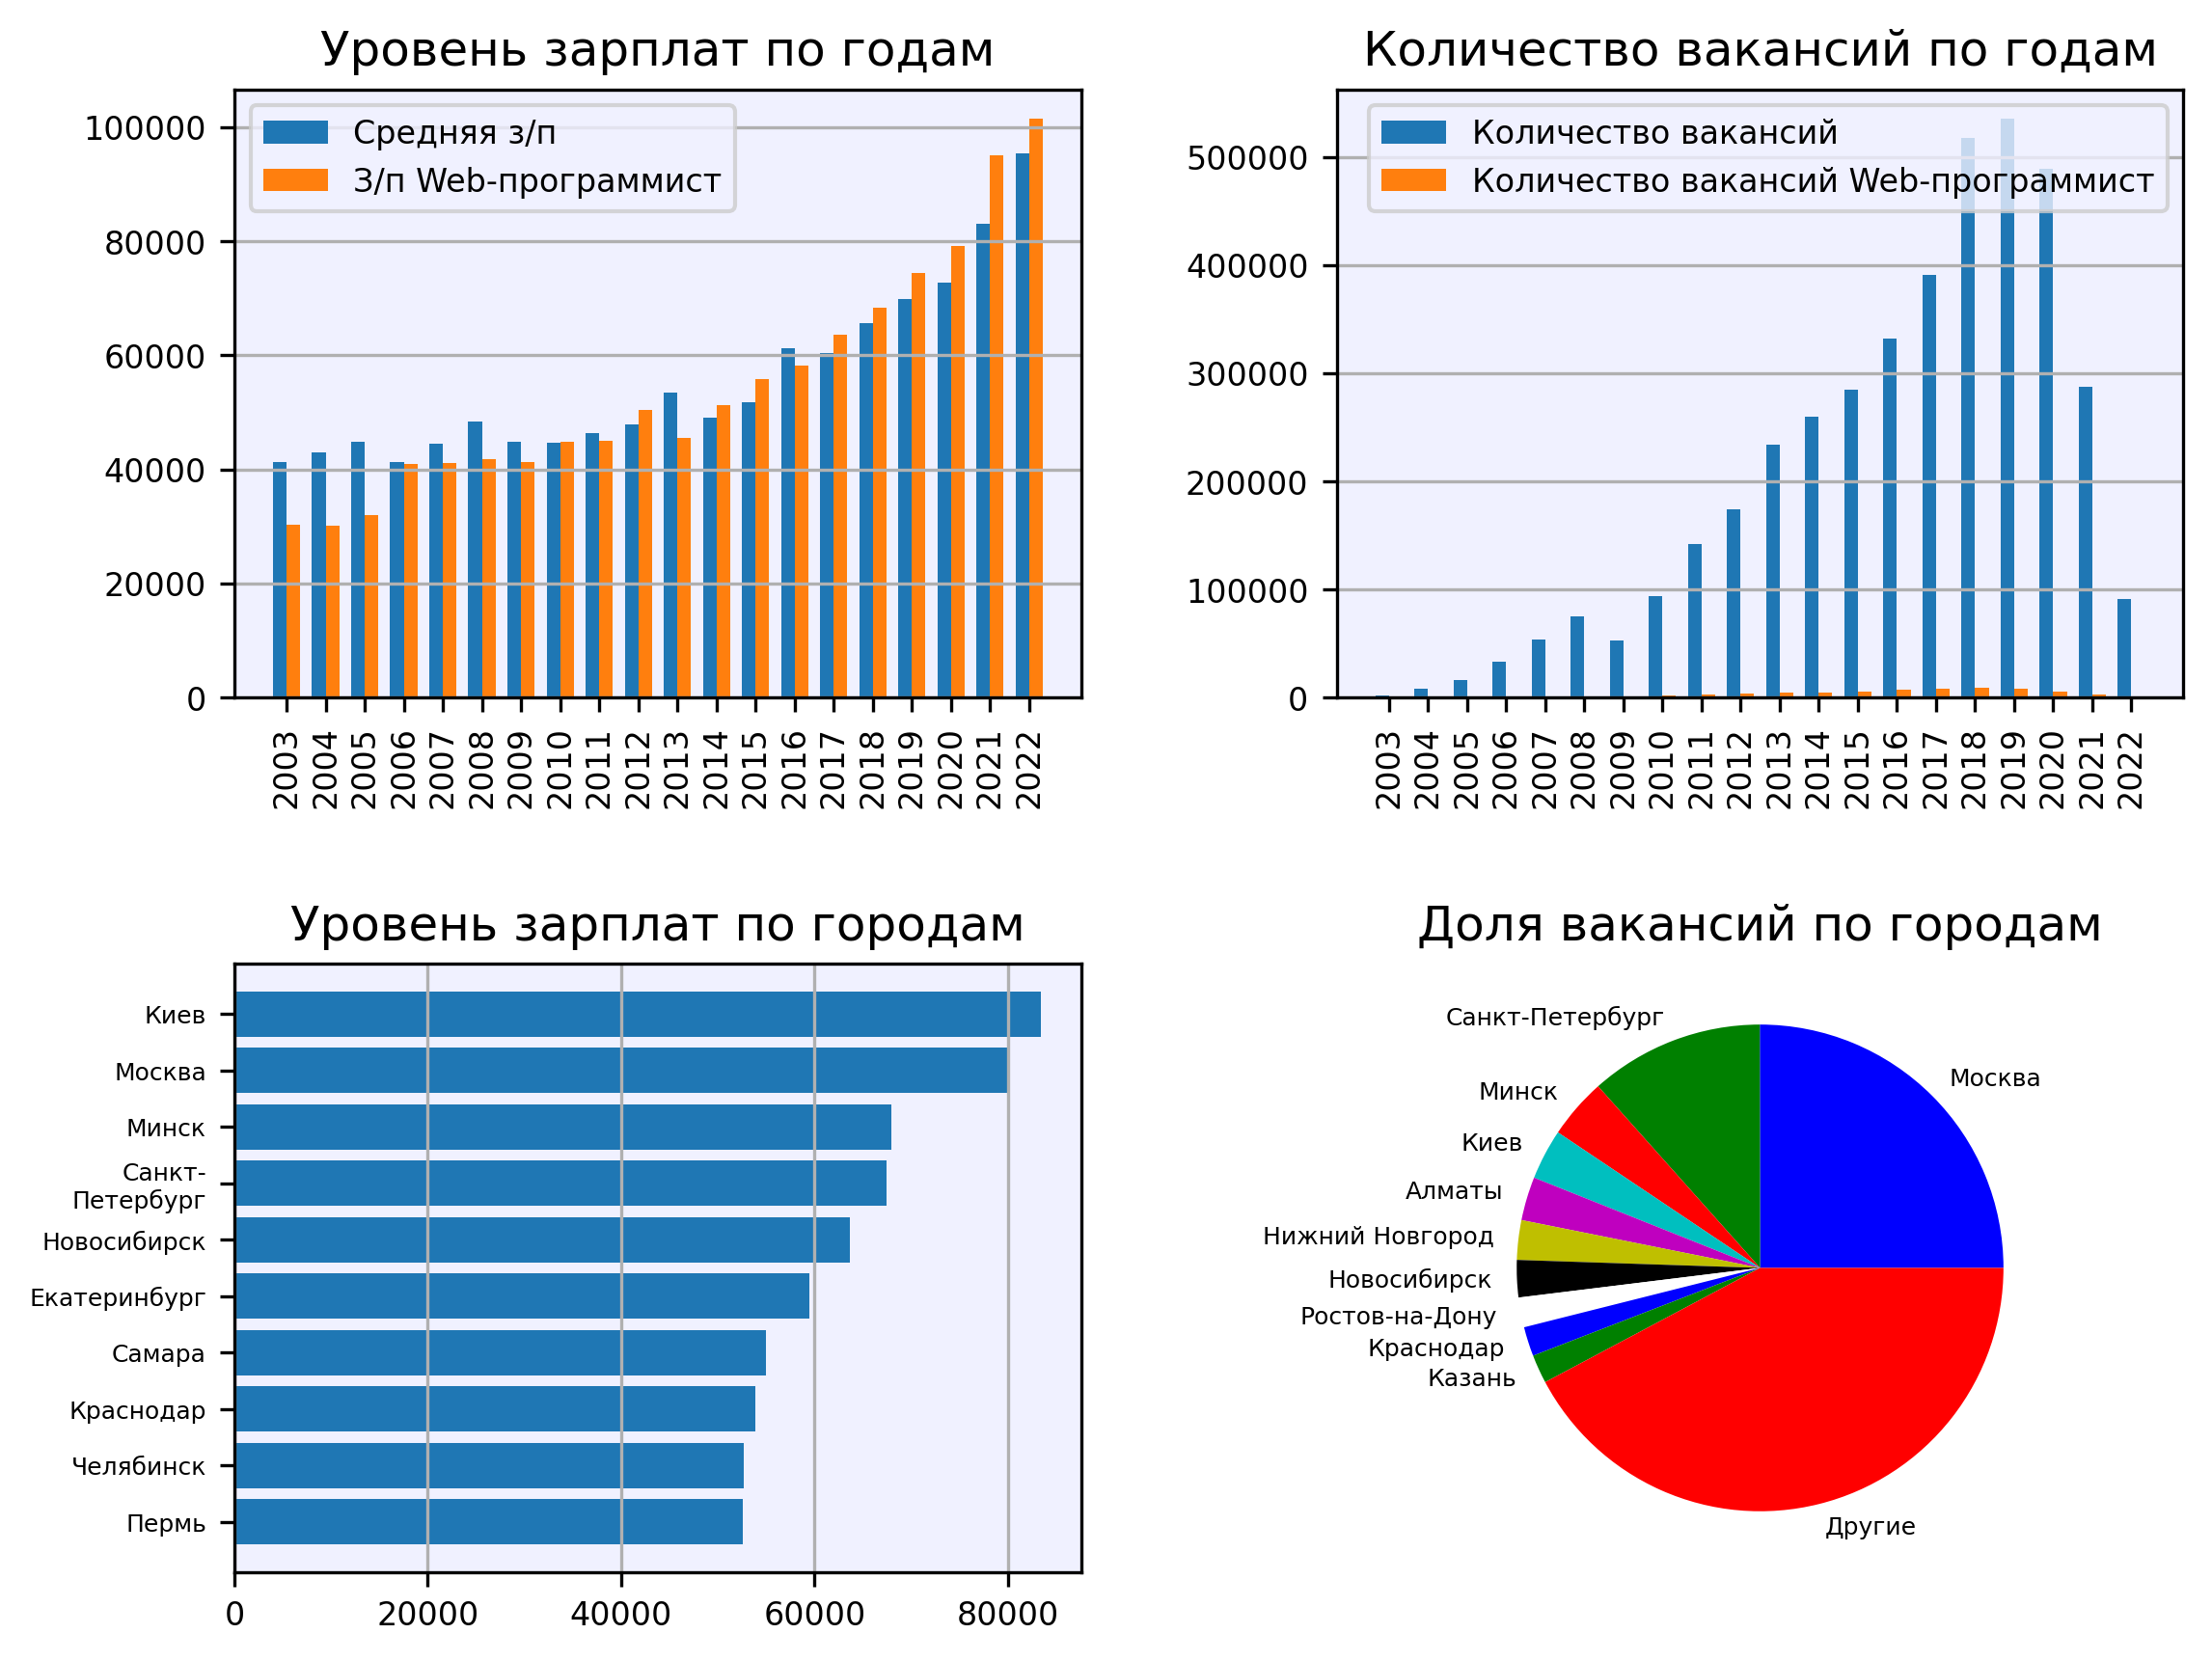

In [12]:
s_all = {}
s_filtered = {}

for year in result.salaries.keys():
    s_all[year] = [result.salaries[year], result.count[year]]
    s_filtered[year] = [result.salaries_vac[year], result.count_vac[year]]

image_generator = Graph('Web-программист')
image_generator.draw(
    s_all,
    s_filtered,
    list(result.area_count),
    list(result.area_sal.items()),
)

In [13]:

def extract_skills(x, key, skill_dict):
    skills = x['key_skills']

    if not isinstance(skills, str): return

    for skill in skills.split('\n'):
        skill_dict[key][skill] = skill_dict[key].get(skill, 0) + 1

In [14]:
skills_years = {}

for result_year in data_arr:
    filtered_year = result_year.filtered
    skills_years[result_year.year] = {}
    filtered_year.apply(lambda x: extract_skills(x, result_year.year, skills_years), axis=1)

In [35]:
skill_dict = {}
for year_skill in sorted(skills_years):
    skill_arr = []
    for s in list(sorted(skills_years[year_skill].items(), key=lambda x: -x[1]))[:10]:
        skill_arr.append(s)

    if len(skill_arr) != 0:
        skill_dict[year_skill] = skill_arr

print(skill_dict)

{'2015': [('JavaScript', 699), ('PHP', 696), ('HTML', 553), ('MySQL', 509), ('CSS', 499), ('HTML5', 479), ('jQuery', 456), ('CSS3', 421), ('Ajax', 377), ('PHP5', 311)], '2016': [('JavaScript', 1958), ('PHP', 1737), ('HTML', 1473), ('CSS', 1293), ('jQuery', 1289), ('MySQL', 1289), ('HTML5', 1176), ('CSS3', 1001), ('PHP5', 782), ('Git', 762)], '2017': [('JavaScript', 2882), ('PHP', 2575), ('HTML', 2143), ('CSS', 2103), ('MySQL', 2014), ('jQuery', 1835), ('HTML5', 1539), ('Git', 1214), ('CSS3', 1111), ('1С-Битрикс', 1045)], '2018': [('JavaScript', 3434), ('PHP', 3192), ('HTML', 2614), ('MySQL', 2494), ('CSS', 2484), ('jQuery', 2162), ('HTML5', 1837), ('Git', 1557), ('CSS3', 1353), ('1С-Битрикс', 1178)], '2019': [('JavaScript', 3333), ('PHP', 2806), ('HTML', 2545), ('CSS', 2453), ('MySQL', 2084), ('jQuery', 1980), ('HTML5', 1564), ('Git', 1530), ('CSS3', 1193), ('1С-Битрикс', 1169)], '2020': [('JavaScript', 3146), ('PHP', 2459), ('CSS', 2222), ('HTML', 2162), ('MySQL', 2143), ('jQuery', 17